<h1 align='center'> Diabetes Diagnostic Model Based On Convolutional Neural Network</h1>


-----

|  **Contacts**  ||
|--------------------------|--------
|      **Supervisor**      |  **Dr Md Zakir Hossain**
|        **Student**       |  **Zeyu Zhang**





## I. Import Libraries

In [1]:
# Code Imports
# Every import is here, you may need to uncomment additional items as necessary.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

import sqlite3
from sqlite3 import Error
from scipy import stats
from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.linear_model import LogisticRegressionCV   # Logistic Regression with Cross Validation
from sklearn.decomposition import PCA as RandomizedPCA        # PCA
from sklearn.neighbors import KNeighborsClassifier      # k-Nearest Neighbours
from sklearn.preprocessing import LabelEncoder          # encooding variables
from sklearn.preprocessing import StandardScaler        # encooding variables
from sklearn.model_selection import train_test_split    # testing our models
#from sklearn.preprocessing import OneHotEncoder         # nominal variable
from sklearn.metrics import confusion_matrix            # scoring
from sklearn.tree import DecisionTreeClassifier         # decision trees
from sklearn.tree import DecisionTreeRegressor          # decision trees
from sklearn import tree                                # decision trees
from sklearn.decomposition import PCA                   # PCA 
from sklearn.cluster import KMeans                      # KMeans Clustering
from sklearn import metrics                             # metrics

# import math module for roundings
import math

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import sklearn metrics for validation
import sklearn.metrics as skm

# import cdist for SSE (Distortion)
from scipy.spatial.distance import cdist

# cross validation
from sklearn.model_selection import cross_validate 

## II. KNN Classifier & Validation

The reason why we choose KNN is that it is very efficient unless the input data is high-dimensional.

This section includes:

- **Spliting** dataframe for training, testing and validation
- **Scaling** the predictor to normalize the impact factor, since each predictor has a different degree of impact on the outcome
    - Here, we use `StandardScaler()` to achieve this, we can also use `heatmap` alternatively.
- Finding the **Optimal K** for knn model based on iteration
- **Training** KNN model
- Creating a **validation** set
- **Output** the validation, training and testing scores for the best model

In [2]:
# Method StandardScaler()

def data_split(data):
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2, random_state=0)
    return train_x, test_x, train_y, test_y

def data_scaling(train_x, test_x):

    ss = StandardScaler()
    ss_model = ss.fit(train_x)
    train_x_scaled = ss_model.transform(train_x)
    test_x_scaled = ss_model.transform(test_x)
    return train_x_scaled, test_x_scaled

def knn_classifier(df):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    #-------------------------
    # find the optimal K
    # create a validation set
    train_x_scaled, val_x_scaled, train_y, val_y = train_test_split(train_x_scaled,train_y, test_size=0.2, random_state=0)

    best_k = -1
    best_score = -1
    for k in [1,2,3,5,7,9,15,31,51,train_x_scaled.shape[0]]:
        knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
        knn_model = knn.fit(train_x_scaled, train_y) # scaled X, un-scaled y
        train_score = knn.score(train_x_scaled, train_y)
        val_score = knn.score(val_x_scaled, val_y)
        print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
        # find the best k
        if best_score <= val_score:
            best_score = val_score
            best_model = knn_model
            best_k = k

    print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


    # Print the validation, training and testing scores for the best model  
    print("Best Model Validation Score: {:.4f}".format(best_model.score(val_x_scaled, val_y)), 
    "\n Training Score: {:.4f}".format(best_model.score(train_x_scaled, train_y)),
    "\n Test Score: {:.4f}".format(best_model.score(test_x_scaled, test_y)))

## III. Logistic Regression with 5 Fold Cross Validation

The reason why we choose Logistic Regression is that it's one of the most suitable classifier for binomial classification.

In [3]:
def lg_classifier(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    clf = LogisticRegressionCV(cv=5, multi_class='ovr', random_state=0).fit(X, y)
    print("Validation score of Logistic Regression is " + str(clf.score(X, y)))

## IV. Screening of Datasets

First we need to study the correlation between the predictors and outcomes. In order to find the appropriate dataset as the research object, the screening of multiple is indispensable.  


### Canidate Data Sources

- **`CDC_BRFSS2015`** - It's a dataset of 253,680 survey responses to the CDC's BRFSS2015.
- **`NIDDK_Pima`** - It's a dataset of 768 females at least 21 years old of Pima Indian heritage responses to National Institute of Diabetes and Digestive and Kidney Diseases's survey.
- **`Sylhet`** - This dataset has been collected using direct questionnaires from 520 patients of Sylhet Diabetes Hospital in Sylhet, Bangladesh.
- **`BIT_2019`** - This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra
- **`John`** - These data are courtesy of Dr John Schorling, Department of Medicine, University of Virginia School of Medicine. The data consist of 19 variables on 403 subjects from 1046 subjects who were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia for African Americans. 

- **`John_2`** - We also keep another version of Diabetes data of Dr John Schorling

-----





## 1. CDC BRFSS2015 Database

This is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015 with 22 features. These features are either questions directly asked of participants, or calculated variables based on individual participant responses.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Diabetes_binary| 0 = no diabetes 1 = diabetes |
| HighBP      | 0 = no high BP 1 = high BP |
| HighChol    | 0 = no high cholesterol 1 = high cholesterol |
| CholCheck       | 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years |
| BMI            | Body Mass Index |
| Smoker      | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes |
| Stroke       | (Ever told) you had a stroke. 0 = no 1 = yes |
| HeartDiseaseorAttack        | coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes |
| PhysActivity       | physical activity in past 30 days - not including job 0 = no 1 = yes |
| Fruits        | Consume Fruit 1 or more times per day 0 = no 1 = yes |
| Veggies        | Consume Vegetables 1 or more times per day 0 = no 1 = yes |
| HvyAlcoholConsump        | (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes |
| AnyHealthcare        | Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes |
| NoDocbcCost        | Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes |
| GenHlth       | Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor |
| MentHlth        | days of poor mental health scale 1-30 days |
| PhysHlth        | physical illness or injury days in past 30 days scale 1-30 |
| DiffWalk        | Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes |
| Sex        | 0 = female 1 = male |
| Age        | 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older |
| Education        | Education level scale 1-6 1 = Never attended school or only kindergarten 2 = elementary etc. |
| Income        | Income scale 1-8 1 = less than `$10000`, 5 = less than `$35000`, 8 = `$75000` or more |






In [4]:
# Read 'CDC_BRFSS2015.csv'
cdc_df = pd.read_csv("./data/CDC_BRFSS2015.csv")

# Drop NaN value
print("Any null value:", any(cdc_df.isnull()))
print("Any NaN value:", any(cdc_df.isna()))
print("Before Droping NaN Number of Rows:", len(cdc_df))

cdc_df = cdc_df.dropna()
print("After Droping NaN Number of Rows:", len(cdc_df))

# Move 'Diabetes_binary' column to the end of dataframe
cdc_df['Diabetes_binary'] = cdc_df.pop('Diabetes_binary')

cdc_df.tail()



Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 253680
After Droping NaN Number of Rows: 253680


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0,0.0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0,1.0
253677,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,0.0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0,0.0
253679,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,2.0,1.0


In [5]:
# Correlation contingency table
cdc_corr = cdc_df.corr()
cdc_corr

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
HighBP,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,-0.125267,-0.040555,-0.061266,...,0.017358,0.300530,0.056456,0.161212,0.223618,0.052207,0.344452,-0.141358,-0.171235,0.263129
HighChol,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,-0.078046,-0.040859,-0.039874,...,0.013310,0.208426,0.062069,0.121751,0.144672,0.031205,0.272318,-0.070802,-0.085459,0.200276
CholCheck,0.098508,0.085642,1.000000,0.034495,-0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,...,-0.058255,0.046589,-0.008366,0.031775,0.040585,-0.022115,0.090321,0.001510,0.014259,0.064761
BMI,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,-0.147294,-0.087518,-0.062275,...,0.058206,0.239185,0.085310,0.121141,0.197078,0.042950,-0.036618,-0.103932,-0.100069,0.216843
Smoker,0.096991,0.091299,-0.009929,0.013804,1.000000,0.061173,0.114441,-0.087401,-0.077666,-0.030678,...,0.048946,0.163143,0.092196,0.116460,0.122463,0.093662,0.120641,-0.161955,-0.123937,0.060789
Stroke,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,-0.069151,-0.013389,-0.041124,...,0.034804,0.177942,0.070172,0.148944,0.176567,0.002978,0.126974,-0.076009,-0.128599,0.105816
HeartDiseaseorAttack,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,-0.087299,-0.019790,-0.039167,...,0.031000,0.258383,0.064621,0.181698,0.212709,0.086096,0.221618,-0.099600,-0.141011,0.177282
PhysActivity,-0.125267,-0.078046,0.004190,-0.147294,-0.087401,-0.069151,-0.087299,1.000000,0.142756,0.153150,...,-0.061638,-0.266186,-0.125587,-0.219230,-0.253174,0.032482,-0.092511,0.199658,0.198539,-0.118133
Fruits,-0.040555,-0.040859,0.023849,-0.087518,-0.077666,-0.013389,-0.019790,0.142756,1.000000,0.254342,...,-0.044243,-0.103854,-0.068217,-0.044633,-0.048352,-0.091175,0.064547,0.110187,0.079929,-0.040779
Veggies,-0.061266,-0.039874,0.006121,-0.062275,-0.030678,-0.041124,-0.039167,0.153150,0.254342,1.000000,...,-0.032232,-0.123066,-0.058884,-0.064290,-0.080506,-0.064765,-0.009771,0.154329,0.151087,-0.056584


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.073
$


In [6]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(cdc_corr.iloc[-1,:-1])/21)

Weighted Average: 0.07319491246647232


-----

###  1.1 KNN with PCA

Since it's a considerably large dataset with 253680 tuples and 21 predictors. Although it's not high-dimensional but it's obviously time consuming when training the model on a personal computer.

So in order to address this issue, we should implement Dimensionality Reduction based on Principal Components Analysis (PCA).

To begin with, we have to plot the Explained Variance vs Principal Component Diagraph to determine how many dimensions do we need to keep.



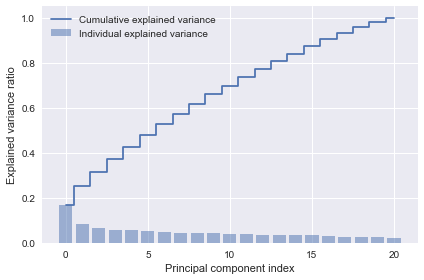

In [7]:
# Scale the dataset; This is very important before you apply PCA

train_x, test_x, train_y, test_y = data_split(cdc_df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
train_x_scaled, val_x_scaled, train_y, val_y = train_test_split(train_x_scaled,train_y, test_size=0.2, random_state=0)

# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(train_x_scaled)

# Determine explained variance using explained_variance_ratio_ attribute
exp_var_pca = pca.explained_variance_ratio_


# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The more components you include the more variance you explain and the less information you loose but there's a **trade off**.

Ideally, we should choose the number of components to include in the model by adding the explained variance ratio of each component until it reaches a total of around **0.8** to avoid overfitting.

Since we do not have powerful computational resources. We have to select 5 dimensions for the trade-off.

In [8]:
pca = RandomizedPCA(n_components = 5).fit(train_x_scaled)

X_train_pca = pca.transform(train_x_scaled)

X_test_pca = pca.transform(test_x_scaled)

X_val_pca = pca.transform(val_x_scaled)

best_k = -1
best_score = -1
for k in [1,2,3,5,7,9,15,31,51]:
    knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
    knn_model = knn.fit(X_train_pca, train_y) # scaled X, un-scaled y
    train_score = knn.score(X_train_pca, train_y)
    val_score = knn.score(X_val_pca, val_y)
    print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
    # find the best k
        # find the best k
    if best_score <= val_score:
        best_score = val_score
        best_model = knn_model
        best_k = k

print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


# Print the validation, training and testing scores for the best model  
print("Best Model Validation Score: {:.4f}".format(best_model.score(X_val_pca, val_y)), 
"\n Training Score: {:.4f}".format(best_model.score(X_train_pca, train_y)),
"\n Test Score: {:.4f}".format(best_model.score(X_test_pca, test_y)))


k: 1 Training Score: 0.994468910720335 Validation Score:  0.795954568971889
k: 2 Training Score: 0.9002864094114749 Validation Score:  0.8513883071768213
k: 3 Training Score: 0.9004465523082135 Validation Score:  0.8332799526965434
k: 5 Training Score: 0.8844753780296264 Validation Score:  0.8439232304318904
k: 7 Training Score: 0.8771580795171076 Validation Score:  0.8513143955258814
k: 9 Training Score: 0.8737827600012319 Validation Score:  0.8527926285446796
k: 15 Training Score: 0.869218687444181 Validation Score:  0.858188179063293
k: 31 Training Score: 0.8662067691170583 Validation Score:  0.8607504496292099
k: 51 Training Score: 0.8651535216038927 Validation Score:  0.8624996920347877
The best k is 51 and the best val score is 0.8625
Best Model Validation Score: 0.8625 
 Training Score: 0.8652 
 Test Score: 0.8599


####  Validation without PCA (took around 5000s)

k: 1 Training Score: 0.9966369991684888 Validation Score:  0.804109487792259

k: 2 Training Score: 0.9022389208832496 Validation Score:  0.8526201680258199

k: 3 Training Score: 0.9027255089156478 Validation Score:  0.8379117494887778

k: 5 Training Score: 0.884777185796557 Validation Score:  0.8492695065165439

k: 7 Training Score: 0.8792522558590743 Validation Score:  0.8529158146295794

k: 9 Training Score: 0.8759323704228389 Validation Score:  0.8561186528369755

k: 15 Training Score: 0.8708509131224785 Validation Score:  0.8595432259971914

k: 31 Training Score: 0.867888269532814 Validation Score:  0.862302594298948

k: 51 Training Score: 0.8666995164916387 Validation Score:  0.8628446130725074

**Luckily, we can see the trade-off between explained variance and information we keeped based on PCA does not cause to many losses compare with the traditional KNN (21 predictors), as long as we select the optimal K.**

-----

###  1.2 Logistic Regression

In [29]:
lg_classifier(cdc_df)

Validation score of Logistic Regression is 0.863603752759382


-----
## 2. NIDDK Pima Indians Diabetes Database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Pregnancies | Number of times pregnant |
| Glucose | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| BloodPressure | Diastolic blood pressure (mm Hg) |
| SkinThickness | Triceps skin fold thickness (mm) |
| Insulin | 2-Hour serum insulin (mu U/ml) |
| BMI | Body mass index (weight in kg/(height in m)^2) |
| DiabetesPedigreeFunction | Diabetes pedigree function |
| Age | Age (years) |
| Outcome | Class variable (0 or 1) |





In [9]:
# Read 'NIDDK_Pima.csv'
niddk_df = pd.read_csv("./data/NIDDK_Pima.csv")

# Drop NaN value
print("Any null value:", any(niddk_df.isnull()))
print("Any NaN value:", any(niddk_df.isna()))
print("Before Droping NaN Number of Rows:", len(niddk_df))

niddk_df = niddk_df.dropna()
print("After Droping NaN Number of Rows:", len(niddk_df))

niddk_df.tail()

Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 768
After Droping NaN Number of Rows: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [10]:
# Correlation contingency table
niddk_corr = niddk_df.corr()
niddk_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.208
$

In [11]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(niddk_corr.iloc[-1,:-1])/8)

Weighted Average: 0.2079678511272704


-----

### 2.1 KNN

In [12]:
knn_classifier(niddk_df)

k: 1 Training Score: 1.0 Validation Score:  0.7398373983739838
k: 2 Training Score: 0.8126272912423625 Validation Score:  0.7317073170731707
k: 3 Training Score: 0.8207739307535642 Validation Score:  0.7154471544715447
k: 5 Training Score: 0.7922606924643585 Validation Score:  0.7398373983739838
k: 7 Training Score: 0.7841140529531568 Validation Score:  0.7560975609756098
k: 9 Training Score: 0.780040733197556 Validation Score:  0.7560975609756098
k: 15 Training Score: 0.7556008146639511 Validation Score:  0.7560975609756098
k: 31 Training Score: 0.7556008146639511 Validation Score:  0.7398373983739838
k: 51 Training Score: 0.7494908350305499 Validation Score:  0.7398373983739838
k: 491 Training Score: 0.6435845213849287 Validation Score:  0.6260162601626016
The best k is 15 and the best val score is 0.7561
Best Model Validation Score: 0.7561 
 Training Score: 0.7556 
 Test Score: 0.8247


-----

###  2.2 Logistic Regression

In [13]:
lg_classifier(niddk_df)

Validation score of Logistic Regression is 0.7786458333333334


-----
## 3. Sylhet Hospital Diabetes Risk Prediction Dataset

This has been collected using direct questionnaires from the patients of Sylhet Diabetes
Hospital in Sylhet, Bangladesh and approved by a doctor.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age        | 20-65 |
| Gender        | 1. Male, 2.Female |
| Polyuria        | 1.Yes, 2.No. |
| Polydipsia        | 1.Yes, 2.No |
| sudden weight loss        | 1.Yes, 2.No. |
| weakness        | 1.Yes, 2.No. |
| Polyphagia        | 1.Yes, 2.No. |
| Genital thrush        | 1.Yes, 2.No. |
| visual blurring        | 1.Yes, 2.No. |
| Itching        | 1.Yes, 2.No. |
| Irritability        | 1.Yes, 2.No. |
| delayed healing        | 1.Yes, 2.No. |
| partial paresis        | 1.Yes, 2.No. |
| muscle stiffness        | 1.Yes, 2.No. |
| Alopecia       | 1.Yes, 2.No. |
| Obesity        | 1.Yes, 2.No. |
| Class        | 1.Positive, 2.Negative. |









In [14]:
# Read 'Sylhet.csv'
sylhet_df = pd.read_csv("./data/Sylhet.csv")

# Drop NaN value
print("Any null value:", any(sylhet_df.isnull()))
print("Any NaN value:", any(sylhet_df.isna()))
print("Before Droping NaN Number of Rows:", len(sylhet_df))

sylhet_df = sylhet_df.dropna()
print("After Droping NaN Number of Rows:", len(sylhet_df))

# Encode textual columns
le = LabelEncoder()
for each in list(sylhet_df.columns.values)[1:]:
    sylhet_df[each] = le.fit_transform(sylhet_df[each])

sylhet_df.tail()

Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 520
After Droping NaN Number of Rows: 520


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0
519,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Correlation contingency table
sylhet_corr = sylhet_df.corr()
sylhet_corr

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
Age,1.000000,0.062872,0.199781,0.137382,0.064808,0.224596,0.315577,0.096519,0.402729,0.296559,0.201625,0.257501,0.232742,0.307703,0.321691,0.140458,0.108679
Gender,0.062872,1.000000,-0.268894,-0.312262,-0.281840,-0.124490,-0.219968,0.208961,-0.208092,-0.052496,-0.013735,-0.101978,-0.332288,-0.090542,0.327871,-0.005396,-0.449233
Polyuria,0.199781,-0.268894,1.000000,0.598609,0.447207,0.263000,0.373873,0.087273,0.235095,0.088289,0.237740,0.149873,0.441664,0.152938,-0.144192,0.126567,0.665922
Polydipsia,0.137382,-0.312262,0.598609,1.000000,0.405965,0.332453,0.316839,0.028081,0.331250,0.128716,0.203446,0.115691,0.442249,0.180723,-0.310964,0.098691,0.648734
sudden weight loss,0.064808,-0.281840,0.447207,0.405965,1.000000,0.282884,0.243511,0.089858,0.068754,-0.004516,0.140340,0.088140,0.264014,0.109756,-0.202727,0.169294,0.436568
weakness,0.224596,-0.124490,0.263000,0.332453,0.282884,1.000000,0.180266,0.027780,0.301043,0.309440,0.146698,0.335507,0.272982,0.263164,0.090490,0.045665,0.243275
Polyphagia,0.315577,-0.219968,0.373873,0.316839,0.243511,0.180266,1.000000,-0.063712,0.293545,0.144390,0.239466,0.263980,0.373569,0.320031,-0.053498,0.029785,0.342504
Genital thrush,0.096519,0.208961,0.087273,0.028081,0.089858,0.027780,-0.063712,1.000000,-0.148408,0.125336,0.160551,0.136111,-0.195612,-0.100188,0.204847,0.053828,0.110288
visual blurring,0.402729,-0.208092,0.235095,0.331250,0.068754,0.301043,0.293545,-0.148408,1.000000,0.291191,0.077095,0.177767,0.364156,0.412369,0.014604,0.109005,0.251300
Itching,0.296559,-0.052496,0.088289,0.128716,-0.004516,0.309440,0.144390,0.125336,0.291191,1.000000,0.114006,0.453316,0.116669,0.215575,0.266506,0.001894,-0.013384


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.104
$

In [16]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(niddk_corr.iloc[-1,:-1])/16)

Weighted Average: 0.1039839255636352


-----

### 3.1 KNN

In [17]:
knn_classifier(sylhet_df)

k: 1 Training Score: 1.0 Validation Score:  0.9523809523809523
k: 2 Training Score: 0.9578313253012049 Validation Score:  0.9404761904761905
k: 3 Training Score: 0.9668674698795181 Validation Score:  0.9404761904761905
k: 5 Training Score: 0.927710843373494 Validation Score:  0.9166666666666666
k: 7 Training Score: 0.9246987951807228 Validation Score:  0.9047619047619048
k: 9 Training Score: 0.9126506024096386 Validation Score:  0.9047619047619048
k: 15 Training Score: 0.9126506024096386 Validation Score:  0.8928571428571429
k: 31 Training Score: 0.8765060240963856 Validation Score:  0.8571428571428571
k: 51 Training Score: 0.822289156626506 Validation Score:  0.8452380952380952
k: 332 Training Score: 0.5993975903614458 Validation Score:  0.6785714285714286
The best k is 1 and the best val score is 0.9524
Best Model Validation Score: 0.9524 
 Training Score: 1.0000 
 Test Score: 0.9904


-----

### 3.2 Logistic Regression

In [18]:
lg_classifier(sylhet_df)

Validation score of Logistic Regression is 0.9326923076923077


-----
## 4. Birla Institute of Technology, Mesra Diabetes Dataset

This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra, Ranchi-835215 for research, non-commercial purposes only. An article is also published implementing this dataset. For more information and citation of this dataset please refer:

Tigga, N. P., & Garg, S. (2020). Prediction of Type 2 Diabetes using Machine Learning Classification Methods. Procedia Computer Science, 167, 706-716. DOI: https://doi.org/10.1016/j.procs.2020.03.336

There is a total of 952 instances with 17 independent predictor variables and one binary target or dependent variable, `Diabetes`

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age |less than 40, 40-49, 50-59, 60 or older|
| Gender        |Male, Female|
| Family_Diabetes        |yes, no|
| highBP |yes, no|
| PhysicallyActive        |none, less than half an hr, more than half an hr, one hr or more|
| BMI        |Body mass index|
| Smoking       |yes, no|
| Alcohol        |yes, no|
| Sleep        |in numerical hrs|
| SoundSleep        |in numerical hrs|
| RegularMedicine        |yes, no|
| JunkFood        |occasionally, sometimes, often, very often, always|
| Stress        |not at all, sometimes, very often, always|
| BPLevel      |normal, high, low|
| Pregancies        |Times|
| Pdiabetes    |0, yes, no|
| UriationFreq       |not much, quite often|
| Diabetic   |yes, no|


In [19]:
# Read 'BIT_2019.csv'
bit_df = pd.read_csv("./data/BIT_2019.csv")

# Drop NaN value
print("Any null value:", any(bit_df.isnull()))
print("Any NaN value:", any(bit_df.isna()))
print("Before Droping NA Number of Rows:", len(bit_df))

bit_df = bit_df.dropna()
print("After Droping NA Number of Rows:", len(bit_df))

# Reset the Index after dropping NaN
bit_df = bit_df.reset_index(drop=True)

# Encode textual columns
le = LabelEncoder()
for each in ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'RegularMedicine', 'JunkFood', 'Stress', 'BPLevel', 'Pdiabetes', 'UriationFreq', 'Diabetic']:
    bit_df[each] = le.fit_transform(bit_df[each])


bit_df.tail()


Any null value: True
Any NaN value: True
Before Droping NA Number of Rows: 952
After Droping NA Number of Rows: 905


,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
900,3,1,1,0,1,25.0,0,0,8,6,0,2,2,4,0.0,0,0,1
901,2,1,1,1,1,27.0,0,0,6,5,1,1,2,2,0.0,0,1,1
902,2,1,0,1,2,23.0,0,0,6,5,1,1,2,2,0.0,0,0,0
903,2,1,0,1,0,27.0,0,1,6,5,1,1,3,2,0.0,0,0,0
904,2,0,1,1,3,30.0,0,0,7,4,1,1,2,2,2.0,0,1,1


In [20]:
# Correlation contingency table
bit_corr = bit_df.corr()
bit_corr

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
Age,1.000000,0.064747,-0.144349,-0.208265,0.029465,-0.265265,0.145087,0.092412,0.000255,-0.008837,-0.271644,0.073097,-0.024002,0.204031,-0.134973,-0.078008,-0.019530,-0.295988
Gender,0.064747,1.000000,-0.104370,0.023263,0.002772,-0.099109,0.284550,0.319937,-0.073934,0.005613,-0.135879,-0.052096,0.000123,-0.024021,-0.504220,-0.141997,-0.177185,-0.051777
Family_Diabetes,-0.144349,-0.104370,1.000000,0.065699,0.049356,0.131971,-0.025561,0.024745,0.038942,0.043966,0.186807,0.076771,-0.044799,-0.112145,0.103463,0.023331,0.034915,0.263889
highBP,-0.208265,0.023263,0.065699,1.000000,-0.087451,0.157034,-0.014162,0.111603,-0.071086,-0.139597,0.448864,-0.037932,-0.093367,-0.660610,0.047913,0.033328,0.130865,0.374823
PhysicallyActive,0.029465,0.002772,0.049356,-0.087451,1.000000,-0.151845,-0.031674,-0.028462,0.075271,0.139063,-0.072240,0.029222,-0.112982,0.109437,0.093966,-0.058032,-0.195429,0.072803
BMI,-0.265265,-0.099109,0.131971,0.157034,-0.151845,1.000000,0.011619,0.018979,-0.061319,-0.267754,0.181882,0.000387,0.016965,-0.165227,-0.045647,0.114958,0.221090,0.152796
Smoking,0.145087,0.284550,-0.025561,-0.014162,-0.031674,0.011619,1.000000,0.518514,-0.022510,-0.018336,-0.041829,0.018133,-0.016814,-0.015987,-0.139765,-0.017814,-0.021224,-0.013656
Alcohol,0.092412,0.319937,0.024745,0.111603,-0.028462,0.018979,0.518514,1.000000,-0.012598,0.052131,0.075526,0.026742,-0.023402,-0.132319,-0.192998,-0.063971,-0.086214,0.064051
Sleep,0.000255,-0.073934,0.038942,-0.071086,0.075271,-0.061319,-0.022510,-0.012598,1.000000,0.538689,-0.102283,0.015070,-0.015948,0.099988,0.042553,0.080715,-0.093906,-0.063654
SoundSleep,-0.008837,0.005613,0.043966,-0.139597,0.139063,-0.267754,-0.018336,0.052131,0.538689,1.000000,-0.116770,0.044498,-0.003377,0.121810,0.153701,0.030370,-0.271819,-0.003710


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.061
$

In [21]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(bit_corr.iloc[-1,:-1])/17)

Weighted Average: 0.06083750193613845


-----

### 4.1 KNN

In [22]:
knn_classifier(bit_df)

k: 1 Training Score: 0.9758203799654577 Validation Score:  0.9172413793103448
k: 2 Training Score: 0.9620034542314335 Validation Score:  0.9103448275862069
k: 3 Training Score: 0.9585492227979274 Validation Score:  0.8689655172413793
k: 5 Training Score: 0.92573402417962 Validation Score:  0.8
k: 7 Training Score: 0.9067357512953368 Validation Score:  0.8206896551724138
k: 9 Training Score: 0.8791018998272885 Validation Score:  0.8344827586206897
k: 15 Training Score: 0.8670120898100173 Validation Score:  0.7862068965517242
k: 31 Training Score: 0.8687392055267703 Validation Score:  0.8275862068965517
k: 51 Training Score: 0.8255613126079447 Validation Score:  0.7793103448275862
k: 579 Training Score: 0.7202072538860104 Validation Score:  0.7172413793103448
The best k is 1 and the best val score is 0.9172
Best Model Validation Score: 0.9172 
 Training Score: 0.9758 
 Test Score: 0.9282


-----

### 4.2 Logistic Regression

In [23]:
lg_classifier(bit_df)

Validation score of Logistic Regression is 0.8784530386740331


-----
## 5. Diabetes data of Dr John Schorling

These data are courtesy of Dr John Schorling, Department of Medicine, University of Virginia School of Medicine. The data consist of 19 variables on 403 subjects from 1046 subjects who were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia for African Americans. According to Dr John Hong, Diabetes Mellitus Type II (adult onset diabetes) is associated most strongly with obesity. The waist/hip ratio may be a predictor in diabetes and heart disease. DM II is also agssociated with hypertension - they may both be part of "Syndrome X". The 403 subjects were the ones who were actually screened for diabetes. Glycosolated hemoglobin > 7.0 is usually taken as a positive diagnosis of diabetes.

####  Attribute Information

A data frame with 205 observations on the following 12 variables.

| Column Name    | Expression    |
| :------------- | :------------- |
| id|subject id |
| chol| Total Cholesterol|
| stab.glu|Stabilized Glucose |
|  hdl| High Density Lipoprotein|
| ratio |Cholesterol/HDL Ratio |
|  glyhb| Glycosolated Hemoglobin|
|  location| a factor with levels (Buckingham,Louisa)|
| age |age (years) |
|  gender| male or female|
|  height|height (inches)|
|  weight| weight (pounds)|
|  frame| a factor with levels (small,medium,large)|
|  bp.1s| First Systolic Blood Pressure|
|  bp.1d| First Diastolic Blood Pressure|
|  bp.2s|Second Diastolic Blood Pressure |
|  bp.2d| Second Diastolic Blood Pressure|
|  waist| waist in inches|
|  hip|hip in inches |
|  time.ppn| Postprandial Time when Labs were Drawn in minutes|
|  AgeGroups| Categorized age|
|  height.europe|height (cm) |
|  weight.europe| weight (kg)|
|  BMI| Categorized BMI|


In [24]:
# Read 'John.csv'
john_df = pd.read_csv("./data/John.csv")


# Delete redundant and useless/irrelevant columns
del john_df['bp.2s']
del john_df['bp.2d']
del john_df['height.europe']
del john_df['weight.europe']
del john_df['id']
del john_df['location']

# Drop NaN value
print("Before Droping NA Number of Rows:", len(john_df))

john_df = john_df.dropna()
print("After Droping NA Number of Rows:", len(john_df))

# Reset the Index after dropping NaN
john_df = john_df.reset_index(drop=True)


# Encode textual columns
le = LabelEncoder()
for each in ['gender', 'frame', 'AgeGroups']:
    john_df[each] = le.fit_transform(john_df[each])


john_df.loc[john_df.glyhb <= 7, 'glyhb'] = 0
john_df.loc[john_df.glyhb > 7, 'glyhb'] = 1

# Move 'glyhb' columns to the end of dataframe
john_df['glyhb'] = john_df.pop('glyhb')

john_df.tail()

Before Droping NA Number of Rows: 403
After Droping NA Number of Rows: 366


,chol,stab.glu,hdl,ratio,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn,AgeGroups,BMI,glyhb
361,301.0,90,118.0,2.6,89,0,61.0,115.0,1,218.0,90.0,31.0,41.0,210.0,4,21.728862,0.0
362,296.0,369,46.0,6.4,53,1,69.0,173.0,1,138.0,94.0,35.0,39.0,210.0,1,25.547402,1.0
363,284.0,89,54.0,5.3,51,0,63.0,154.0,1,140.0,100.0,32.0,43.0,180.0,1,27.279628,0.0
364,194.0,269,38.0,5.1,29,0,69.0,167.0,2,120.0,70.0,33.0,40.0,20.0,3,24.661365,1.0
365,199.0,76,52.0,3.8,41,0,63.0,197.0,1,120.0,78.0,41.0,48.0,255.0,0,34.896666,0.0


In [25]:
# Correlation contingency table
john_corr = john_df.corr()
john_corr

,chol,stab.glu,hdl,ratio,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn,AgeGroups,BMI,glyhb
chol,1.000000,0.165448,0.170973,0.484038,0.241605,-0.045122,-0.063230,0.079790,-0.091914,0.201949,0.159042,0.144090,0.098597,0.006239,-0.046387,0.109185,0.214116
stab.glu,0.165448,1.000000,-0.180105,0.298896,0.278551,0.086064,0.082476,0.188801,-0.172587,0.151425,0.025697,0.233692,0.144833,-0.048458,-0.084755,0.136285,0.673534
hdl,0.170973,-0.180105,1.000000,-0.690231,0.000215,-0.105023,-0.068592,-0.282983,0.244740,0.029509,0.072245,-0.278300,-0.222217,0.079939,0.072557,-0.239826,-0.158193
ratio,0.484038,0.298896,-0.690231,1.000000,0.171569,0.093348,0.070898,0.278899,-0.248392,0.105347,0.034841,0.315498,0.207892,-0.053828,-0.089084,0.233046,0.300542
age,0.241605,0.278551,0.000215,0.171569,1.000000,0.066752,-0.097137,-0.046213,-0.239684,0.433032,0.058915,0.170261,0.018297,-0.026905,-0.104281,0.009621,0.284613
gender,-0.045122,0.086064,-0.105023,0.093348,0.066752,1.000000,0.690619,0.093271,-0.196724,0.024720,0.051546,-0.039777,-0.273547,0.033163,0.011723,-0.253793,0.011446
height,-0.063230,0.082476,-0.068592,0.070898,-0.097137,0.690619,1.000000,0.243296,-0.045577,-0.044412,0.043452,0.041808,-0.117182,-0.006181,-0.060114,-0.263981,0.009966
weight,0.079790,0.188801,-0.282983,0.278899,-0.046213,0.093271,0.243296,1.000000,-0.465338,0.096243,0.180505,0.851923,0.829845,-0.062217,-0.003838,0.863994,0.166064
frame,-0.091914,-0.172587,0.244740,-0.248392,-0.239684,-0.196724,-0.045577,-0.465338,1.000000,-0.179349,-0.083595,-0.492868,-0.372520,-0.078010,0.017240,-0.427266,-0.138715
bp.1s,0.201949,0.151425,0.029509,0.105347,0.433032,0.024720,-0.044412,0.096243,-0.179349,1.000000,0.619846,0.209764,0.151426,-0.074904,-0.089698,0.121103,0.191489


Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.134
$

In [26]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(john_corr.iloc[-1,:-1])/16)

Weighted Average: 0.1339549376746186


-----

### 5.1 KNN

In [27]:
knn_classifier(john_df)

k: 1 Training Score: 1.0 Validation Score:  0.7796610169491526
k: 2 Training Score: 0.9141630901287554 Validation Score:  0.864406779661017
k: 3 Training Score: 0.9184549356223176 Validation Score:  0.864406779661017
k: 5 Training Score: 0.9098712446351931 Validation Score:  0.8813559322033898
k: 7 Training Score: 0.8969957081545065 Validation Score:  0.8983050847457628
k: 9 Training Score: 0.8927038626609443 Validation Score:  0.9152542372881356
k: 15 Training Score: 0.8841201716738197 Validation Score:  0.9152542372881356
k: 31 Training Score: 0.8626609442060086 Validation Score:  0.8813559322033898
k: 51 Training Score: 0.8412017167381974 Validation Score:  0.864406779661017
k: 233 Training Score: 0.8369098712446352 Validation Score:  0.864406779661017
The best k is 15 and the best val score is 0.9153
Best Model Validation Score: 0.9153 
 Training Score: 0.8841 
 Test Score: 0.8919


-----

### 5.2 Logistic Regression

In [28]:
lg_classifier(john_df)

Validation score of Logistic Regression is 0.9234972677595629
